# PyNEST - Brunel Network

**Modeling networks of spiking neurons using NEST**

**CNS 2021, 03.07.2021**

**[Jasper Albers](mailto:j.albers@fz-juelich.de), [Barna Zajzon](mailto:b.zajzon@fz-juelich.de)**

<img src="img/erdos-renyi-ei.png" alt="sketch" width="400" align="center"/>

Here, we will simulate a neural network reproducing the asynchronous irregular state described in

`Brunel (2000) Dynamics of sparsely connected networks of excitatory and inhibitory spiking neurons. Journal of Computational Neuroscience 8(3):183-208`

Adjusting the parameters appropriately, we can also reproduce the synchronous irregular / synchronous regular / asynchronous regular state.

For more NEST background see [part 2 of the official PyNEST tutorial](https://nest-simulator.readthedocs.io/en/latest/tutorials/pynest_tutorial/part_2_populations_of_neurons.html).

In [1]:
%matplotlib notebook
# import NEST & NEST rasterplot
import nest
import nest.raster_plot

## Set parameters

In [2]:
# simulation parameters
simtime = 1000.            # simulation time (ms)
dt = 0.1                   # simulation resolution (ms)

In [3]:
# network parameters
gamma = 0.25               # relative number of inhibitory connections
NE = 5000                  # number of excitatory neurons (10.000 in [1])
NI = int(gamma * NE)       # number of inhibitory neurons
N_rec = 50                 # record from 100 (50 e + 50 i) neurons
CE = 1000                  # indegree from excitatory neurons
CI = int(gamma * CE)       # indegree from inhibitory neurons

In [4]:
# synapse parameters
w = 0.1                    # excitatory synaptic weight (mV)
g = 5.                     # relative inhibitory to excitatory synaptic weight
d = 1.5                    # synaptic transmission delay (ms)

In [5]:
# neuron paramters
V_th = 20.                 # spike threshold (mV)
tau_m = 20.                # membrane time constant (ms)
neuron_params = {
    'C_m': 1.0,            # membrane capacity (pF)
    'E_L': 0.,             # resting membrane potential (mV)
    'I_e': 0.,             # external input current (pA)
    'V_m': 0.,             # membrane potential (mV)
    'V_reset': 10.,        # reset membrane potential after a spike (mV)
    'V_th': V_th,          #
    't_ref': 2.0,          # refractory period (ms)
    'tau_m': tau_m,        #
}

In [6]:
# external input parameters
nu_th = V_th / (w * tau_m) # external rate needed to evoke activity (spikes/ms)
nu_ex = 2.0 * nu_th        # set external rate above threshold
p_rate = 1e3 * nu_ex       # external rate (spikes/s)

## Configure NEST

In [7]:
# configure kernel
nest.ResetKernel()
nest.SetKernelStatus({
    'resolution': dt,      # set simulation resolution
    'print_time': True,    # enable printing of simulation progress (-> terminal)
    'local_num_threads': 2 # use two threads to build & simulate the network
})

## Create neurons and devices

In [8]:
# set default parameters for neurons and create neurons
nest.SetDefaults('iaf_psc_delta', neuron_params)
neurons_e = nest.Create('iaf_psc_delta', NE)
neurons_i = nest.Create('iaf_psc_delta', NI)

# create poisson generator and set 'rate' to p_rate
pgen = nest.Create('poisson_generator', params={'rate': p_rate})

# create spike recorders
spikes_e = nest.Create('spike_recorder')
spikes_i = nest.Create('spike_recorder')

## Create connections

In [9]:
# create excitatory connections

# synapse specification
syn_exc = {'delay': d, 'weight': w}
# connection specification (other options: distributions, fixed outdegree, ...)
conn_exc = {'rule': 'fixed_indegree', 'indegree': CE}
# connect stuff
nest.Connect(neurons_e, neurons_e, conn_exc, syn_exc)
nest.Connect(neurons_e, neurons_i, conn_exc, syn_exc)

In [10]:
# create inhibitory connections

# synapse specification
syn_inh = {'delay': d, 'weight': - g * w}
# connection specification
conn_inh = {'rule': 'fixed_indegree', 'indegree': CI}
# connect stuff
nest.Connect(neurons_i, neurons_e, conn_inh, syn_inh)
nest.Connect(neurons_i, neurons_i, conn_inh, syn_inh)

In [11]:
# connect poisson generator using the excitatory connection weight
nest.Connect(pgen, neurons_i, syn_spec=syn_exc)
nest.Connect(pgen, neurons_e, syn_spec=syn_exc)

In [12]:
# connect N_rec excitatory / inhibitory neurons to spike recorders
nest.Connect(neurons_e[:N_rec], spikes_e)
nest.Connect(neurons_i[:N_rec], spikes_i)

## Simulate and analyse

In [13]:
# simulate
nest.Simulate(simtime) 

In [14]:
# calculate mean firing rate in spikes per second
events_ex = spikes_e.get('n_events')
events_in = spikes_i.get('n_events')
rate_ex = events_ex / simtime / N_rec * 1e3
rate_in = events_in / simtime / N_rec * 1e3
mean_rate = (rate_ex + rate_in) / 2.
print('Mean firing rate: {} Hz'.format(mean_rate))

Mean firing rate: 37.89 Hz


<IPython.core.display.Javascript object>


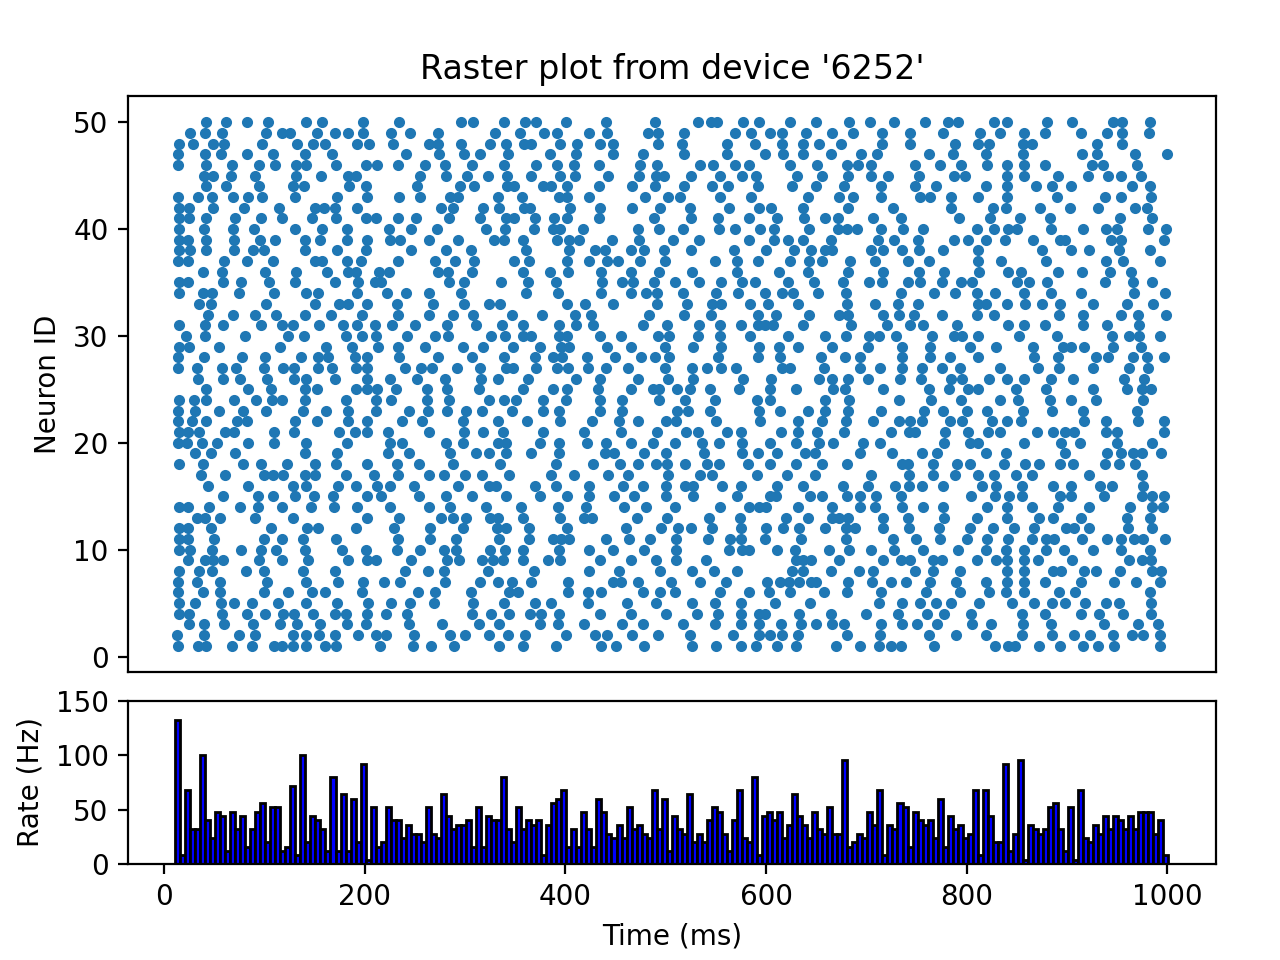

<IPython.core.display.Javascript object>


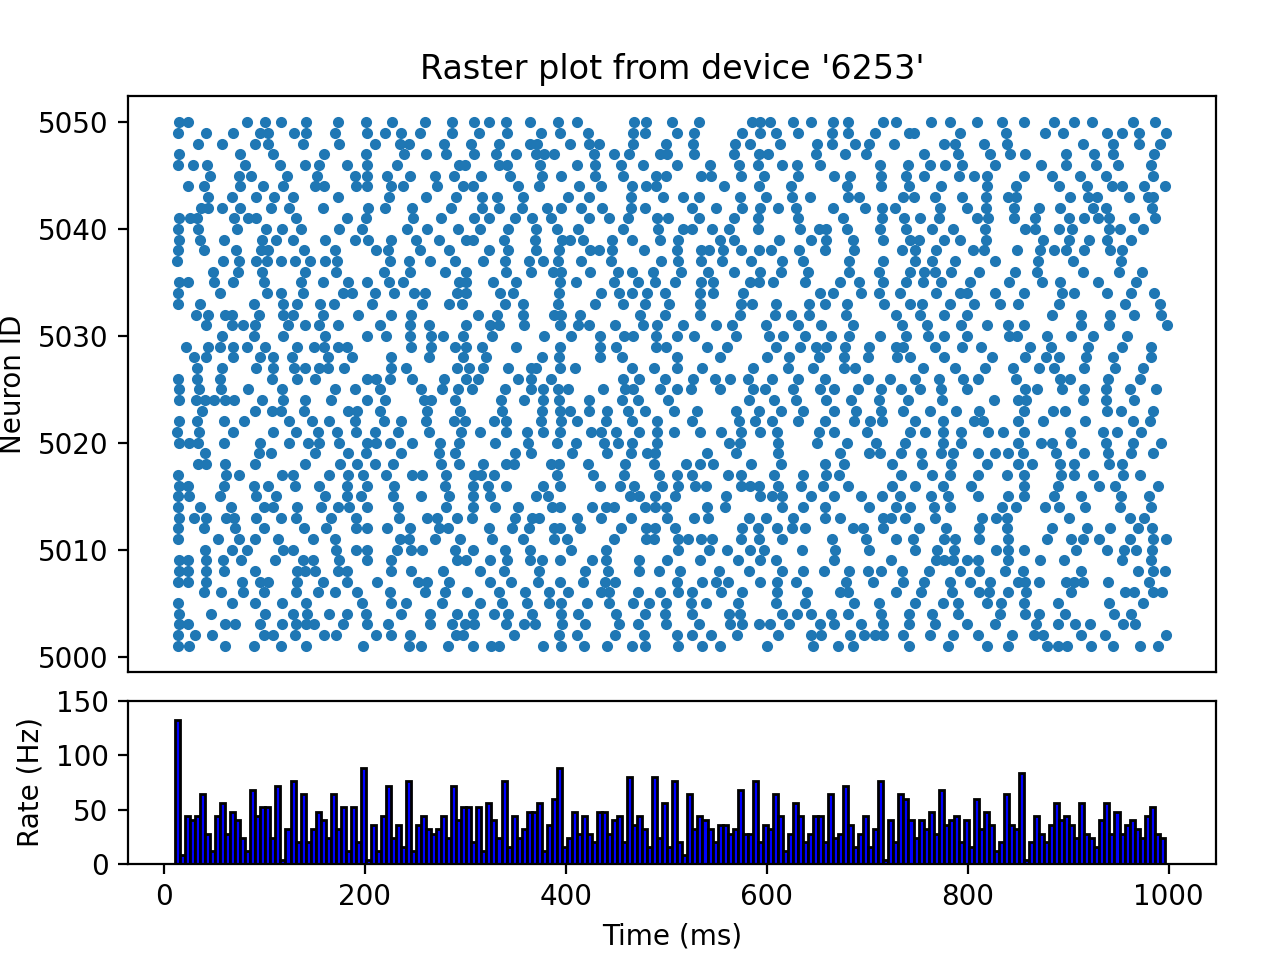

In [16]:
# raster plot of spiking activity using nest.raster_plot
nest.raster_plot.from_device(spikes_e, hist=True)
nest.raster_plot.from_device(spikes_i, hist=True)

## Dynamical regimes

<img src="img/Brunel2000.png" alt="sketch" width="450" align="left"/>

The network can be in four dynamical regimes depending on the parameters g and nu_ex (Brunel 2000, Fig. 8):

(a) synchronous regular

(b) synchronous irregular, fast oscillations

(c) asynchronous irregular

(d) synchronous irregular, slow oscillations

<img src="img/Brunel2000II.png" alt="sketch" width="350" align="left"/>

This is the phase diagram of the network showing which parameters lead to a certain regime (Brunel 2000, Fig. 8).

## Bonus tasks
1. Try to get the other four dynamical regimes in the simulation.
2. What happens if you [increase the synaptic weight](https://www.nature.com/articles/nn.3658) w in the asynchronous irregular regime?
3. What happens if there is [heterogeneity in the indegrees](https://doi.org/10.1016/j.neuron.2016.10.027)?